In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy import optimize
#pip install cvxpy
import cvxpy as cp
# pip install DCCP
import dccp

In [2]:
row_data = pd.read_csv("../compas-scores-two-years.csv")

Here are all features of the dataset.

In [3]:
print(list(row_data.columns))

['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


And we decided to use these features, and they are

**sex**: 0 is female, and 1 is male.

**age_cat**: Age Category, 0 is less than 25, 1 is between 25 and 45, 2 is greater than 45

**race**: Sensitive attribute. 0 is African-American, and 1 is Caucasian.

**priors_count**: A continuous variable containing the number of prior crimes committed.  

**c_charge_degree**: 0 is F, and 1 is M.

**two_year_recid**: The response variable. Whether or not the defendant recidivated within two years.


In [4]:
selected_features = ["sex","age_cat","race","priors_count","c_charge_degree","two_year_recid"]

In [5]:
clean_data = row_data[selected_features]
clean_data = clean_data[clean_data['race'].isin(["African-American","Caucasian"])]

clean_data.replace('Male',1,inplace = True)
clean_data.replace('Female',0,inplace = True)

clean_data.replace('African-American',0,inplace = True)
clean_data.replace('Caucasian',1,inplace = True)

clean_data.replace('M',1,inplace = True)
clean_data.replace('F',0,inplace = True)

clean_data.replace('Less than 25',0,inplace = True)
clean_data.replace('25 - 45',1,inplace = True)
clean_data.replace('Greater than 45',2,inplace = True)

We split the training set and testing set 6:1.

In [6]:
x = clean_data[["sex","age_cat","race","priors_count","c_charge_degree"]]
y = clean_data["two_year_recid"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=1/7.0,random_state=1)

This is the most important function for implementing algorithm A4.

In [7]:
def DM(x,y,method=0,c = 0):
    
    # Method 0 is Unconstrained (original) classifier
    # Method 1 is Disparate Mistreatment method (DM)
    # Method 2 is Disparate Mistreatment method with sensitive features (DM_sen)
    
    # "c" is the covariance between the users’sensitive attributes and the signed distance 
    # between the feature vectors of misclassified users and the classifier decision boundary
    
    # This function will return "theta" a list of parameters of logistic regression
    
    
    idx_0 = x["race"] == 0   
    idx_1 = x["race"] == 1
        
    intercept = np.ones((x.shape[0],1))
    x = np.concatenate((x,intercept),axis=1)
    n = x.shape[0]
    c = n*c
    
    theta = cp.Variable(x.shape[1])    
    loss = -cp.sum(cp.multiply(y,x @ theta) - cp.logistic(x @ theta))
    
    if method == 0:
        
        ## Unconstrained (original) classifier (logistic regression)
        
        prob = cp.Problem(cp.Minimize(loss),[])
        result = prob.solve(method = 'dccp')
    
    else:
        x_0 = x[idx_0]
        y_0 = y[idx_0]
        n_0 = x_0.shape[0]

        x_1 = x[idx_1]
        y_1 = y[idx_1]
        n_1 = x_1.shape[0]

        if method == 1:
            
            ## It is Disparate Mistreatment method (DM), sensitive attribute information 
            ## is not used while making decisions, i.e., by keeping user feature vectors (x) 
            ## and the sensitive features (z) disjoint.
            
            x = np.delete(x,2,axis=1) 
            x_0 = np.delete(x_0,2,axis=1) 
            x_1 = np.delete(x_1,2,axis=1) 
            theta = cp.Variable(x.shape[1]) 
            loss = cp.sum(cp.logistic(x @ theta)- cp.multiply(y,x @ theta))        
        
        ## For method = 2, it is Disparate Mistreatment method with sensitive features (DM_sen).
        ## The sensitive attribute information is used for decision making, resulting in 
        ## disparate treatment.

        distance_0 = x_0 @ theta              
        distance_1 = x_1 @ theta        

        g_0 = cp.minimum(0, cp.multiply(y_0, distance_0)) 
        g_1 = cp.minimum(0, cp.multiply(y_1, distance_1)) 

        constraints = []
        ## For here, we need to put two DCCP expressions on both sides of the inequality sign
        constraints.append( n_0/n * cp.sum(g_1) >= -c + n_1/n * cp.sum(g_0) )
        constraints.append( n_0/n * cp.sum(g_1) <=  c + n_1/n * cp.sum(g_0) )

        prob = cp.Problem(cp.Minimize(loss), constraints)
        result = prob.solve(method='dccp')
    
    theta = np.array(theta.value)
    
    return theta          

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def predict(x,theta,disjoint = 0):
    
    ## We can use disjoint = 0 to predict method 0 and method 2,
    ## and use disjoint = 1 to predict method 1.
    
    x0 = np.ones((x.shape[0],1))
    x = np.concatenate((x,x0),axis=1)
    if disjoint != 0:
        x = np.delete(x,2,axis=1) 
    z = np.dot(x,theta)
    h = sigmoid(z)
    pred = (h>0.5).astype(float)
    return pred

In [9]:
idx_a = x_test["race"] == 0   
idx_c = x_test["race"] == 1
x_test_a = x_test[idx_a]
y_test_a = y_test[idx_a]
x_test_c = x_test[idx_c]
y_test_c = y_test[idx_c]

In [10]:
def fnr(y_true,y_pred):
    cm = sklearn.metrics.confusion_matrix(y_true,y_pred)
    return cm[0][1]/(cm[0][1]+cm[0][0]) 
def fpr(y_true,y_pred):
    cm = sklearn.metrics.confusion_matrix(y_true,y_pred)
    return cm[1][0]/(cm[1][1]+cm[1][0]) 

In [11]:
def stat(cm_a,cm_c):
    fnr_a = cm_a[0][1]/(cm_a[0][1]+cm_a[0][0]) 
    fnr_c = cm_c[0][1]/(cm_c[0][1]+cm_c[0][0])
    fpr_a = cm_a[1][0]/(cm_a[1][1]+cm_a[1][0]) 
    fpr_c = cm_c[1][0]/(cm_c[1][1]+cm_c[1][0])
    acc_a = (cm_a[0][0]+ cm_a[1][1])/(cm_a[0][1]+cm_a[0][0] + cm_a[1][1]+cm_a[1][0]) 
    acc_c = (cm_c[0][0]+ cm_c[1][1])/(cm_c[0][1]+cm_c[0][0] + cm_c[1][1]+cm_c[1][0]) 
    acc = (cm_a[0][0]+ cm_a[1][1]+cm_c[0][0]+ cm_c[1][1])/(cm_a[0][1]+cm_a[0][0] + cm_a[1][1]+cm_a[1][0]+cm_c[0][1]+cm_c[0][0] + cm_c[1][1]+cm_c[1][0]) 
    D_fnr = fnr_a - fnr_c
    D_fpr = fpr_a - fpr_c
    calibration = abs(acc_a-acc_c)
    dic = {'fnr_a':fnr_a,'fnr_c':fnr_c,'fpr_a':fpr_a,'fpr_c':fpr_c,'acc_a':acc_a,
           'acc_c':acc_c,'acc':acc,'D_fnr':D_fnr,'D_fpr':D_fpr,'calibration':calibration}
    print("For African-American, the false positive rate of is %0.2f%%, false negative rate is %0.2f%%, and the accuracy is %0.2f%%." % (fpr_a*100,fnr_a*100,acc_a*100) ) 
    print("For Caucasian       , the false positive rate of is %0.2f%%, false negative rate is %0.2f%%, and the accuracy is %0.2f%%." % (fpr_c*100,fnr_c*100,acc_c*100) ) 
    print("The diffrent negative positives rate(D_FNR) is %0.2f%%, and the diffrent positive positives rate(D_FPR)is %0.2f%%" % (D_fpr*100,D_fnr*100) ) 
    print("The accuracy is %0.2f%%, and the calibration is %0.2f%%" % (acc*100,calibration*100) ) 
    return dic

## 1. Unconstrained Classifier

In [12]:
thetas = DM(x_train,y_train,method=0)

In [13]:
cm_a = sklearn.metrics.confusion_matrix(y_test_a,(predict(x_test_a,thetas)))
cm_a  ## confusion matrix for African-American

array([[173,  94],
       [ 95, 184]], dtype=int64)

In [14]:
cm_c = sklearn.metrics.confusion_matrix(y_test_c,(predict(x_test_c,thetas)))
cm_c  ## confusion matrix for Caucasian

array([[177,  23],
       [ 82,  51]], dtype=int64)

In [15]:
statistics = stat(cm_a,cm_c) 

For African-American, the false positive rate of is 34.05%, false negative rate is 35.21%, and the accuracy is 65.38%.
For Caucasian       , the false positive rate of is 61.65%, false negative rate is 11.50%, and the accuracy is 68.47%.
The diffrent negative positives rate(D_FNR) is -27.60%, and the diffrent positive positives rate(D_FPR)is 23.71%
The accuracy is 66.55%, and the calibration is 3.08%


The differce is big, and we try to reduce it without significantly reducing the accuracy.

## 2. Disparate Mistreatment method (DM)

We will use this to avoid disparate treatment and disparate mistreatment simultaneously. Disparate mistreatment is avoided by using fairness constraints. Disparate treatment is avoided by ensuring that sensitive attribute information is not used while making decisions, i.e., by keeping user feature vectors (x) and the sensitive features (z) disjoint

In [16]:
thetas = DM(x_train,y_train,method=1,c=0.004)

In [17]:
cm_a = sklearn.metrics.confusion_matrix(y_test_a,(predict(x_test_a,thetas,1)))
cm_a  ## confusion matrix for African-American

array([[133, 134],
       [ 55, 224]], dtype=int64)

In [18]:
cm_c = sklearn.metrics.confusion_matrix(y_test_c,(predict(x_test_c,thetas,1)))
cm_c  ## confusion matrix for Caucasian

array([[131,  69],
       [ 46,  87]], dtype=int64)

In [19]:
statistics = stat(cm_a,cm_c)

For African-American, the false positive rate of is 19.71%, false negative rate is 50.19%, and the accuracy is 65.38%.
For Caucasian       , the false positive rate of is 34.59%, false negative rate is 34.50%, and the accuracy is 65.47%.
The diffrent negative positives rate(D_FNR) is -14.87%, and the diffrent positive positives rate(D_FPR)is 15.69%
The accuracy is 65.42%, and the calibration is 0.08%


The accuracy decreased by 1%, but we succeeded in reducing the diffrence of FNR and diffrence of FPR a lot. It is a great method.

In [20]:
thetas_2 = [None]*50
for c in range(50):
    thetas_2[c] = DM(x_train,y_train,method=1,c=c*3/5000)

In [21]:
acc = np.zeros(50)
C = np.zeros(50)
calibration = np.zeros(50)
d_fnr = np.zeros(50)
d_fpr = np.zeros(50)

for c in range(50):
    C[c] = c*3/5000
    acc[c] = (predict(x_test,thetas_2[c],1) == y_test).mean()
    acc_a = (predict(x_test_a,thetas_2[c],1) == y_test_a).mean()
    acc_c = (predict(x_test_c,thetas_2[c],1) == y_test_c).mean()
    calibration[c] = abs(acc_a-acc_c)
    d_fnr[c] = fnr(y_test_a, predict(x_test_a,thetas_2[c],1)) - fnr(y_test_c, predict(x_test_c,thetas_2[c],1))
    d_fpr[c] = fpr(y_test_a, predict(x_test_a,thetas_2[c],1)) - fpr(y_test_c, predict(x_test_c,thetas_2[c],1))

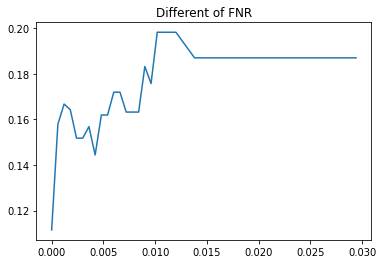

In [22]:
plt.plot(C,d_fnr);
plt.title('Different of FNR');

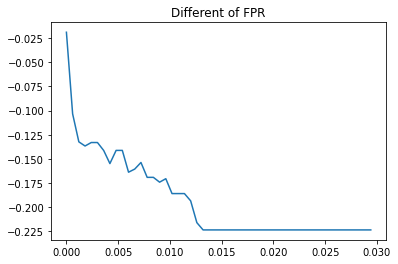

In [23]:
plt.plot(C,d_fpr);
plt.title('Different of FPR');

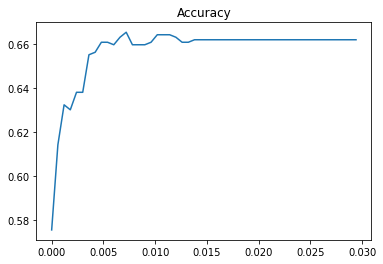

In [24]:
plt.plot(C,acc);
plt.title('Accuracy');

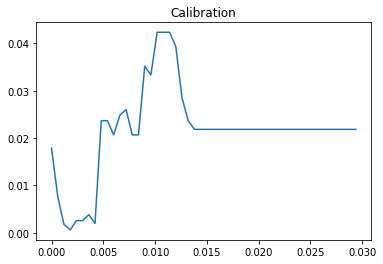

In [25]:
plt.plot(C,calibration);
plt.title('Calibration');

## 3. Disparate Mistreatment method with sensitive attribute (DM_sen)

We will avoid disparate mistreatment only. The user feature vectors (x) and the sensitive features (z) are not disjoint, that is, z is used as a learnable feature. Therefore, the sensitive attribute information is used for decision making, resulting in disparate
treatment.

In [26]:
thetas = DM(x_train,y_train,method=2,c=0.02)

In [27]:
cm_a = sklearn.metrics.confusion_matrix(y_test_a,(predict(x_test_a,thetas)))
cm_a  ## confusion matrix for African-American

array([[173,  94],
       [ 95, 184]], dtype=int64)

In [28]:
cm_c = sklearn.metrics.confusion_matrix(y_test_c,(predict(x_test_c,thetas)))
cm_c  ## confusion matrix for Caucasian

array([[177,  23],
       [ 82,  51]], dtype=int64)

In [29]:
statistics = stat(cm_a,cm_c)

For African-American, the false positive rate of is 34.05%, false negative rate is 35.21%, and the accuracy is 65.38%.
For Caucasian       , the false positive rate of is 61.65%, false negative rate is 11.50%, and the accuracy is 68.47%.
The diffrent negative positives rate(D_FNR) is -27.60%, and the diffrent positive positives rate(D_FPR)is 23.71%
The accuracy is 66.55%, and the calibration is 3.08%


For DM_sen, the accuracy only decreased by 1%, and the diffrence of FNR and diffrence of FPR reduce a lot. It is a very great method to avoid disparate mistreatment.

In [30]:
thetas_3 = [None]*50
for c in range(50):
    thetas_3[c] = DM(x_train,y_train,method=2,c=c*3/5000)

In [31]:
for c in range(50):
    C[c] = c*3/5000
    acc[c] = (predict(x_test,thetas_3[c]) == y_test).mean()
    acc_a = (predict(x_test_a,thetas_3[c]) == y_test_a).mean()
    acc_c = (predict(x_test_c,thetas_3[c]) == y_test_c).mean()
    calibration[c] = abs(acc_a-acc_c)
    d_fnr[c] = fnr(y_test_a, predict(x_test_a,thetas_3[c])) - fnr(y_test_c, predict(x_test_c,thetas_3[c]))
    d_fpr[c] = fpr(y_test_a, predict(x_test_a,thetas_3[c])) - fpr(y_test_c, predict(x_test_c,thetas_3[c]))

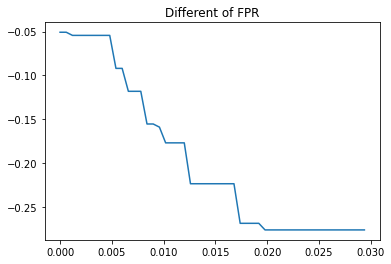

In [32]:
plt.plot(C,d_fpr);
plt.title('Different of FPR');

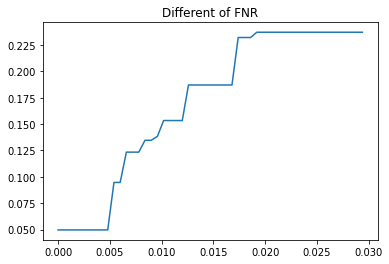

In [33]:
plt.plot(C,d_fnr);
plt.title('Different of FNR');

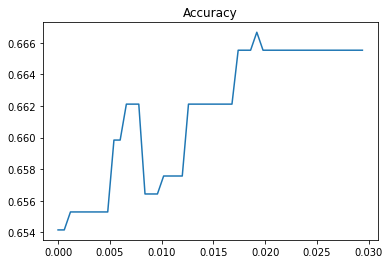

In [34]:
plt.plot(C,acc);
plt.title('Accuracy');

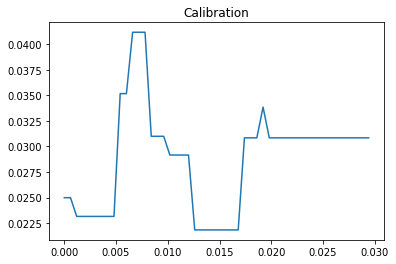

In [35]:
plt.plot(C,calibration);
plt.title('Calibration');